# Evaluation for the third model

In [1]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [3]:
import sys; sys.path.insert(0, '/mnt/src')

## Read Datasets from .csv

In [4]:
from utils.file_io import read_trajectory_datasets

In [5]:
feature_columns = [
    'left_boom_base_yaw_joint', 
    'left_boom_base_pitch_joint',
    'left_boom_main_prismatic_joint',
    'left_boom_second_roll_joint',
    'left_boom_second_yaw_joint',
    'left_boom_top_pitch_joint',
    'left_boom_ee_joint',
    'cable1_property(length,youngsmodule(bend,twist))',
    'cable2_property(length,youngsmodule(bend,twist))',
    'cable3_property(length,youngsmodule(bend,twist))'
]

label_features = [
    ('cable1_lowest_point', np.array([2], dtype=np.int64)),
    ('cable2_lowest_point', np.array([2], dtype=np.int64)),
    ('cable3_lowest_point', np.array([2], dtype=np.int64))
]

normalized_features = [
    ('cable1_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64)),
    ('cable2_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64)),
    ('cable3_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64))
]

In [6]:
data_folder = Path("/mnt/data/")
train_set, test_set, validation_set, visualization_set = read_trajectory_datasets(data_folder, 0.8, 0.15, 0.045, 0.005, 64, 
                                                                                  feature_columns=feature_columns, label_features=label_features, normalized_features=normalized_features)

Reading .csv files: 1it [00:00,  1.59it/s]
/mnt/src/utils/preprocessing.py:132: RuntimeWarning: divide by zero encountered in divide
  return np.where(x_max != x_min, (features - x_min) / (x_max - x_min), 1).astype(dtype=np.float32)
/mnt/src/utils/preprocessing.py:132: RuntimeWarning: invalid value encountered in divide
  return np.where(x_max != x_min, (features - x_min) / (x_max - x_min), 1).astype(dtype=np.float32)


Preprocessing dataframe
Reshaping dataframe for learning


In [7]:
input_shape, output_shape = 16, 3
print(f"Data shape {input_shape} / {output_shape} of total {len(train_set) + len(validation_set) + len(test_set) + len(visualization_set)} data rows!")

Data shape 16 / 3 of total 1678 data rows!


## Load parameter, functions and dataloader

In [8]:
from utils.file_io import define_dataloader_from_subset
import os
import ast
from dotenv import load_dotenv

In [9]:
model_path = Path("/mnt/models/transformer/").absolute()

In [10]:
dotenv_path = model_path / ".env"
load_dotenv(dotenv_path=dotenv_path)

batch_size = int(os.getenv("BATCH_SIZE"))
optimizer = os.getenv("OPTIMIZER")
activation = os.getenv("ACTIVATION")
num_encoder_layer = int(os.getenv("NUM_ENCODER_LAYER"))
pos_encoder_dropout = float(os.getenv("POS_ENCODER_DROPOUT"))
transformer_dropout = float(os.getenv("TRANSFORMER_DROPOUT"))
feedforward_dim = int(os.getenv("FEEDFORWARD_DIM"))
warmup_steps = int(os.getenv("WARMUP_STEPS"))
model_dim_num_heads_projection = ast.literal_eval(os.getenv("MODEL_DIM_NUM_HEADS_PROJECTION"))
num_epochs = int(os.getenv("NUM_EPOCHS"))

In [11]:
train_dataloader, validation_dataloader, test_dataloader = define_dataloader_from_subset(train_set, validation_set, test_set, batch_size=batch_size)

## Load and Train the model

In [12]:
from models.transformer import TransformerEncoderModel, train
from utils.loss_functions import get_loss_function
from utils.optimizer import get_optimizer_function, get_learning_rate_scheduler
from utils.activation import get_activation
from utils.early_stopping import EarlyStopping

In [13]:
activation = get_activation(activation)

In [14]:
model = TransformerEncoderModel(
        num_heads = model_dim_num_heads_projection[1],
        model_dim = model_dim_num_heads_projection[0],
        feedforward_hidden_dim = feedforward_dim,
        num_encoder_layers = num_encoder_layer,
        output_dim = output_shape,
        transformer_dropout = transformer_dropout,
        pos_encoder_dropout = pos_encoder_dropout,
        projection_num_neighbors = model_dim_num_heads_projection[2],
        activation = activation,
        projection_function = None
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
optimizer = get_optimizer_function(optimizer, model, 1)
lr_scheduler = get_learning_rate_scheduler(optimizer, model_dim_num_heads_projection[0], warmup_steps)
loss_function = get_loss_function()

In [16]:
early_stopping = EarlyStopping(10)

In [17]:
_, validation_losses = train(num_epochs, train_dataloader, validation_dataloader, model, loss_function, optimizer, lr_scheduler, model_path, device, early_stopping=early_stopping)

TypeError: Expected state_dict to be dict-like, got <class 'method'>.

## Evaluation

In [ ]:
from utils.evaluation import compute_losses_from, compute_sliding_window_predictions
from utils.visualization import create_plot_for_dimensions

In [ ]:
#model.load(model_path / "checkpoint.pt")

In [ ]:
model.eval()

## 1. Analysis: Compute loss and average inference time on test

In [ ]:
y, y_true, inference_times = compute_sliding_window_predictions(test_dataloader, model, 'cpu')
test_losses = compute_losses_from(y, y_true, get_loss_function())
print(f"The mean squared error of the loaded model on test is: {test_losses.mean()}")
print(f"The average inference time of the loaded model on test is: {inference_times.mean()} seconds.")

The mean squared error of the loaded model on test is: 0.16766151785850525
The average inference time of the loaded model on test is: 0.0029942889232188463 seconds.


## 2. Analysis: Show Cable lowest points

In [ ]:
visualization_dataloader = DataLoader(visualization_set[0], batch_size=1, shuffle=False)

In [ ]:
y, y_true, inference_times = compute_sliding_window_predictions(visualization_dataloader, model, 'cpu')

float64


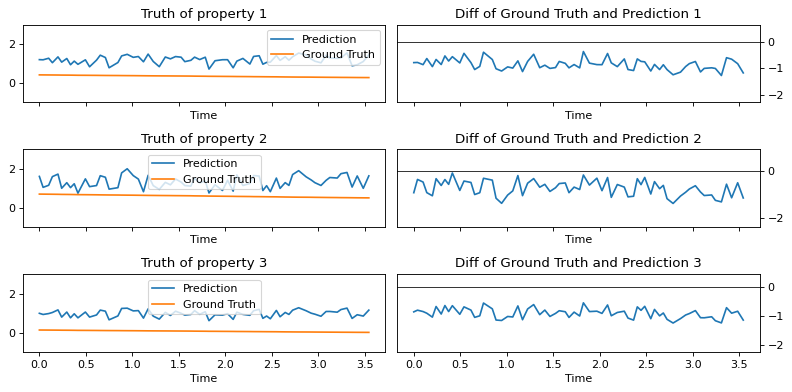

In [ ]:
plot = create_plot_for_dimensions(y.numpy(), y_true.numpy(), visualization_set[1], size=5)
plot.savefig(model_path / "predictions.png")
plot.show()

## 3. Analysis: Show inference times

In [ ]:
import matplotlib.pyplot as plt

from typing import Sequence

In [ ]:
def create_inference_time_plot(inference_times: np.ndarray, figsize: Sequence[float] = None):
    fig = plt.figure(figsize=figsize)
    plt.plot(inference_times)
    plt.title("Inference time per input in visualization dataset")
    plt.ylabel("Time in s")
    return plt


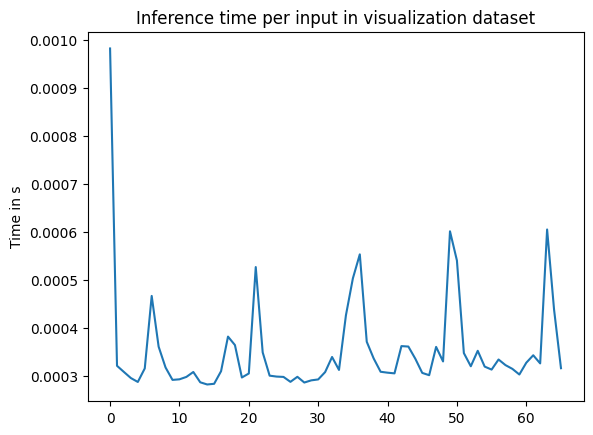

In [ ]:
plot = create_inference_time_plot(inference_times.numpy())
plot.savefig(model_path / "inference_times.png")
plot.show()

## 4. Analysis: Show validation loss over time

In [ ]:
def create_validation_loss_plot(validation_losses: np.ndarray, figsize: Sequence[float] = None):
    fig = plt.figure(figsize=figsize)
    plt.plot(validation_losses)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Validation loss over time")
    return plt

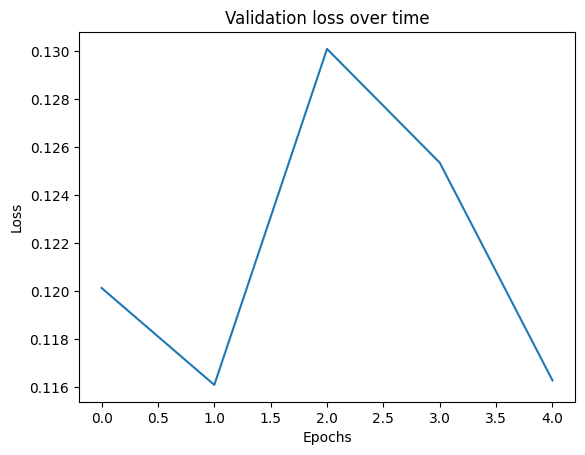

In [ ]:
plot = create_validation_loss_plot(validation_losses)
plot.savefig(model_path / "losses.png")
plot.show()